In [11]:
import os
import sys
import subprocess
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import time

from ctypes import *
%matplotlib widget

In [12]:
m_o = 16
m_n = 14
m_o2 = 32
m_n2 = 28
m_He = 4
m_H = 1
m_Ar = 40
m_p = 1.67 * 10**-27
m_surf = 120*m_p ## averaging all the surfaces

In [13]:
sat = 'GRACEB'
sat_in_filename = 'graceB'
start = dt.datetime(2005,8,23,0,0,0)
stop = dt.datetime(2005,8,28,0,0,0)
no_of_days = int(np.ceil((stop - start)/dt.timedelta(days=1)))
m_grace = 432

In [14]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI Project_1\\Data\\Temp\\"
filepath = "/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/"
os.chdir(filepath)

filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv'
GRACE_Data = pd.read_csv(filename)
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])

In [15]:
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
os.chdir(filepath)
filename = sat + '_MSIS_' + str(start.month).zfill(2) + '_' + str(start.year) + '.csv'
Data_msis = pd.read_csv(filename)

In [16]:
mole_frac = pd.DataFrame({'frac_O':[Data_msis['nO'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))],
                         'frac_O2':[Data_msis['nO2'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))],
                          'frac_N': [Data_msis['nN'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))],
                          'frac_N2': [Data_msis['nN2'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))],
                          'frac_He': [Data_msis['nHe'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))],
                          'frac_H': [Data_msis['nH'][i]/np.sum(Data_msis.iloc[i,2:8]) for i in range(len(Data_msis))]
                         },index = Data_msis.index)

In [17]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\src\\TPMC\\rsm_tool_suite-master\\RSM_Cd\\src\\"  
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/temp/rsm_tool_suite-master-2/RSM_Cd/src/'
os.chdir(filepath)

In [19]:
begin = time.time()
C_D = []; A =[];N = 2000;
for i in range(N):
    urls = open('RSM1.inp', 'r')
    urls1 = open('RSM.inp','w')
    
    lines = urls.readlines()# read all the lines of txt
    
    li = lines[4]
    frac_O = np.round(mole_frac['frac_O'][i],2); frac_O2 = np.round(mole_frac['frac_O2'][i],2); frac_N = np.round(mole_frac['frac_N'][i],2);
    frac_N2 = np.round(mole_frac['frac_N2'][i],2); frac_He = np.round(mole_frac['frac_He'][i],2); frac_H = np.round(mole_frac['frac_H'][i],2);
    
    xsum = round((frac_O + frac_O2 + frac_N + frac_N2 + frac_H + frac_He)-1,2)
    
    frac_O = frac_O - xsum
    
    addn = str(frac_H)+'\t'+str(frac_He)+\
    '\t'+str(frac_N)+'\t'+str(frac_N2) + '\t'+\
    str(frac_O)+'\t'+ str(frac_O2) ;
    
    lines[4] = li[:48] + addn + "\n"

    lines[5] = lines[5][:-7] + "{:.2e}".format(np.sum(Data_msis.iloc[i,2:8])) + "\n"
    
    lines[6] = lines[6][:-6] + "{:.3f}".format(GRACE_Data.iloc[i,6]/1000) + "\n"
    
    lines[7] = lines[7][:-7] + "{:.1f}".format(GRACE_Data.iloc[i,8]) + "\n"
    
    # no changes in line 8
    
    lines[9] = lines[9][:-2] + str(0) + '\n'
    lines[10] = lines[10][:-4] + str(round(np.rad2deg(GRACE_Data.iloc[i,10]),2)) + "\n"
    lines[11] = lines[11][:-4] + str(round(np.rad2deg(GRACE_Data.iloc[i,9]),2)) + "\n"
    
    lines[12] = lines[12][:-10] + "{:.3e}".format(m_surf) + "\n"
    lines[13] = lines[13][:-6] + "{:.1f}".format(m_grace) + "\n"
    
    lines[14] = lines[14][:-15] + 'GRACE1' + "_RSM.dat\n"
    lines[15] = lines[15][:-15] + 'GRACE' + "_area.dat"
    
    urls1.writelines(lines)
    
    urls.close()
    urls1.close()
    
    
    p1 = subprocess.run(['gcc', '-lgsl','-lgslcblas','-lm','-w','RSM.c','-o','./a.out'])
    p2 = subprocess.run(["./a.out"],capture_output=True,text=True)

    output = p2.stdout.splitlines()
    C_D.append(float(output[-5][-12:]))
    # A.append(float(output[-4][-16:-4]))
    
end = time.time()
print(end-begin)

3226.7538549900055


In [20]:
drag_coeff = pd.DataFrame({'C_D':C_D},index = GRACE_Data.index[:N])

In [ ]:
# def __bootstrap__():
#    global __bootstrap__, __loader__, __file__
#    import sys, pkg_resources, imp
#    __file__ = pkg_resources.resource_filename(__name__,'mylib1.so')
#    __loader__ = None; del __bootstrap__, __loader__
#    imp.load_dynamic(__name__,__file__)
# __bootstrap__()

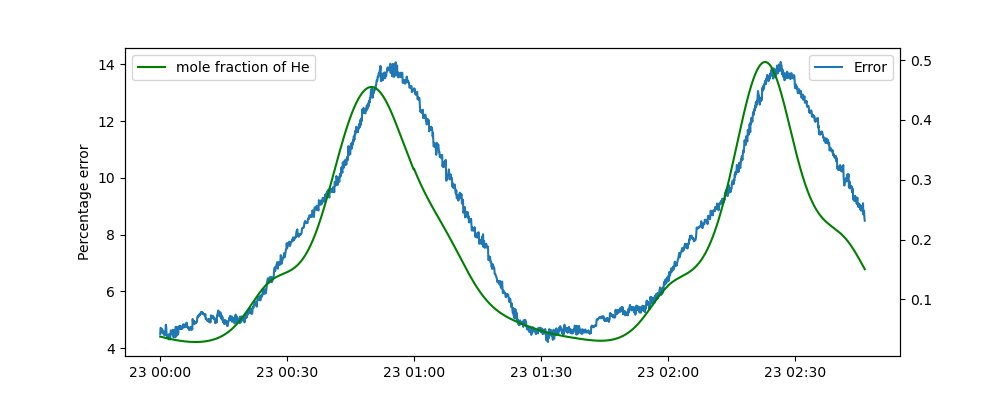

In [37]:
fig,ax1 = plt.subplots(figsize = [10,4])

# ax1.plot(drag_coeff['C_D'],label = 'C_D(TPMC)')
ax1.plot(GRACE_Data.index[:N],((np.array(drag_coeff['C_D']) - np.array(GRACE_Data['CD_New (~)'][:N]))/np.array(GRACE_Data['CD_New (~)'][:N]))*100,label = 'Error')
ax1.legend()
ax1.set_ylabel('Percentage error')

ax2 = ax1.twinx()
ax2.plot(GRACE_Data.index[:N],mole_frac['frac_He'][:N],c = 'green',label = 'mole fraction of He')
ax2.legend()
